# Bounds

First we need some imports.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy import stats
import pylab as plt
import torch
import torchist
import swyft
import pytorch_lightning as pl

## Training data

Now we generate training data.  As simple example, we consider the model

$$
x = z + \epsilon
$$

where the parameter $z \sim \mathcal{N}(\mu = 0, \sigma = 1)$ is standard normal distributed, and $\epsilon \sim \mathcal{N}(\mu = 0, \sigma = 0.1)$ is a small noise contribution.  We are interested in the posterior of $z$ given a measurement of parameter $x$.

In [3]:
class Simulator(swyft.Simulator):
    def __init__(self, bounds = None):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.z_sampler = swyft.RectBoundSampler(stats.norm([0], [1]), bounds = bounds.params[0,0] if bounds else None)

    def build(self, graph):
        z = graph.node('z', self.z_sampler)
        x = graph.node('x', lambda z: z + np.random.randn(1)*0.1, z)
        
sim = Simulator(bounds = None)

In [4]:
samples = sim.sample(10000)

100%|██████████| 10000/10000 [00:08<00:00, 1221.85it/s]


In [5]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.logratios = swyft.LogRatioEstimator_1dim(num_features = 1, num_params = 1, varnames = 'z')

    def forward(self, A, B):
        logratios = self.logratios(A['x'], B['z'])
        return logratios

## Trainer

Training is now done using the `SwyftTrainer` class, which extends `pytorch_lightning.Trainer` by methods like `infer` (see below).

In [6]:
model_checkpoint = pl.callbacks.ModelCheckpoint(monitor = 'val_loss', save_top_k = 1)
logger = pl.loggers.TensorBoardLogger("./lightning_logs", name = "Test1")
trainer = swyft.SwyftTrainer(accelerator = 'gpu', max_epochs = 20, precision = 64, logger = logger, callbacks = [model_checkpoint])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The `swyft.Samples` class provides convenience functions to generate data loaders for training and validation data.

In [7]:
dm = swyft.SwyftDataModule(samples, fractions = [0.8, 0.02, 0.1], num_workers = 3, batch_size = 256)

In [8]:
network = Network()

In [9]:
trainer.fit(network, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | logratios | LogRatioEstimator_1dim | 17.4 K
-----------------------------------------------------
17.4 K    Trainable params
0         Non-trainable params
17.4 K    Total params
0.139     Total estimated model params size (MB)


/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1894: PossibleUserWarning: The number of training batches (34) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0:  97%|█████████▋| 34/35 [00:00<00:00, 55.22it/s, loss=-0.932, v_num=54] 
Validation: 0it [00:00, ?it/s]
Epoch 1:  97%|█████████▋| 34/35 [00:00<00:00, 52.57it/s, loss=-0.966, v_num=54, val_loss=-.676]
Validation: 0it [00:00, ?it/s]
Epoch 2:  97%|█████████▋| 34/35 [00:00<00:00, 47.42it/s, loss=-0.965, v_num=54, val_loss=-.927]
Validation: 0it [00:00, ?it/s]
Epoch 3:  97%|█████████▋| 34/35 [00:00<00:00, 54.49it/s, loss=-0.959, v_num=54, val_loss=-.941]
Validation: 0it [00:00, ?it/s]
Epoch 4:  97%|█████████▋| 34/35 [00:00<00:00, 46.98it/s, loss=-0.972, v_num=54, val_loss=-.943]
Validation: 0it [00:00, ?it/s]
Epoch 5:  97%|█████████▋| 34/35 [00:00<00:00, 53.99it/s, loss=-0.976, v_num=54, val_loss=-.925]
Validation: 0it [00:00, ?it/s]
Epoch 6:  97%|█████████▋| 34/35 [00:00<00:00, 51.17it/s, loss=-0.974, v_num=54, val_loss=-.941]
Validation: 0it [00:00, ?it/s]
Epoch 7:  97%|█████████▋| 34/35 [00:00<00:00, 48.07it/s, loss=-0.967, v_num=54, val_loss=-.947]
Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 35/35 [00:00<00:00, 35.84it/s, loss=-0.992, v_num=54, val_loss=-.945]


In [10]:
prior_samples = sim.sample(N = 10000, targets = ['z'])

100%|██████████| 10000/10000 [00:08<00:00, 1237.94it/s]


In [11]:
obs = swyft.Sample(x = np.array([0.3]))

In [12]:
logratios = trainer.infer(network, obs, prior_samples)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0:  30%|███       | 3/10 [00:00<00:00, 153.42it/s]

/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 155.68it/s]


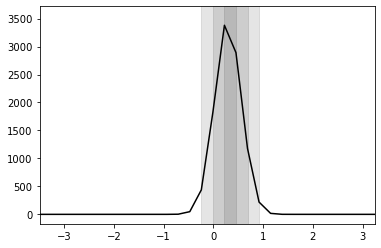

In [13]:
swyft.plot_1d(logratios, "z[0]", ax = plt.gca(), smooth = 1, bins = 30)

In [14]:
bounds = swyft.lightning.bounds.get_rect_bounds(logratios, threshold = 1e-6)
bounds

RectangleBounds(params=tensor([[[-1.7873,  2.2994]]], dtype=torch.float64), parnames=array([['z[0]']], dtype='<U4'))